In [1]:
import os
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def hybrid(img1,img2,cutoff_frequency,Filter):
    assert img1.shape==img2.shape,'shape not match'
    h,w,c=img1.shape
    lowPassed = convolution(img1, Filter(h,w,cutoff_frequency,lowPass=True))
    highPassed = convolution(img2, Filter(h,w,cutoff_frequency, lowPass=False))
    return highPassed+lowPassed,lowPassed,highPassed

def idealFilter(h,w,cutoff_frequency,lowPass):
    """
    :return: (h,w) ndarray
    """
    x0,y0=w//2,h//2
    if lowPass:
        H=np.zeros((h,w))
        for x in range(x0-cutoff_frequency, x0+cutoff_frequency):
            # (x-x0)^2 + (y-y0)^2 = r^2
            for y in range(int(y0-math.sqrt(cutoff_frequency**2-(x-x0)**2)),int(y0+math.sqrt(cutoff_frequency**2-(x-x0)**2))):
                    H[y,x]=1
    else:
        H=np.ones((h,w))
        for x in range(x0-cutoff_frequency,x0+cutoff_frequency):
            for y in range(int(y0-math.sqrt(cutoff_frequency**2-(x-x0)**2)),int(y0+math.sqrt(cutoff_frequency**2-(x-x0)**2))):
                    H[y,x]=0
    return H

def GaussianFilter(h,w,cutoff_frequency, lowPass):
    """
    :return: (h,w) ndarray
    """
    x0,y0=w//2,h//2
    if lowPass:
        H=np.zeros((h,w))
        for x in range(w):
            for y in range(h):
                H[y,x]=math.exp(-1*((x-x0)**2+(y-y0)**2)/(2*cutoff_frequency**2))
    else:
        H=np.ones((h,w))
        for x in range(w):
            for y in range(h):
                H[y,x]-=math.exp(-1*((x-x0)**2+(y-y0)**2)/(2*cutoff_frequency**2))
    return H

def convolution(image, H):
    """
    :param image: (H,W,C) ndarray
    :param H: (H,W) filter ndarray
    """
    h,w,c=image.shape
    image_sp = np.zeros((h,w,c))
    result = np.zeros((h,w,c))
    for channel in range(c):
        image_ = image[:,:,channel] / 255
        """
        Multiply the input image by (-1)^x+y to center the transform.
        """
        for i in range(h):
            for j in range(w):
                image_[i,j]=((-1)**(i+j))*image_[i,j]
        """
        Compute ftt F for input image
        """
        F=(np.fft.fft2(image_))
        image_sp[:,:,channel]=20*np.log(np.abs(F))
        """
        Multiply F by H, compute the inverse ftt of the result
        """
        result[:,:,channel]=np.absolute(np.fft.ifft2(F*H))
    return result

def normalize(img):
    """
    normalize img to 0~1
    """
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)



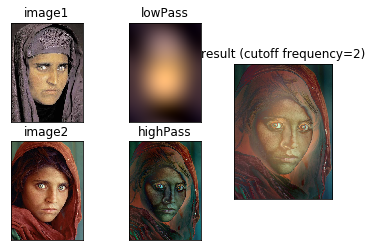

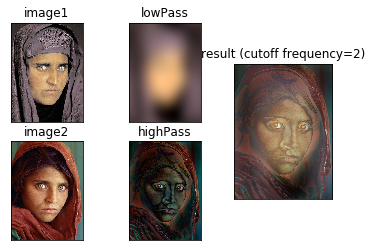

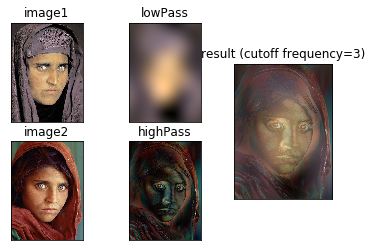

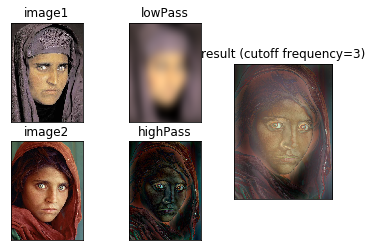

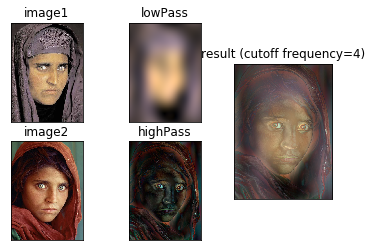

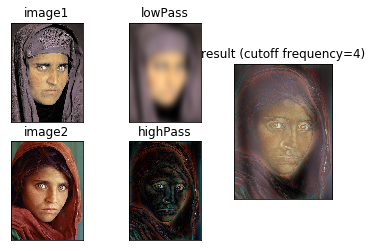

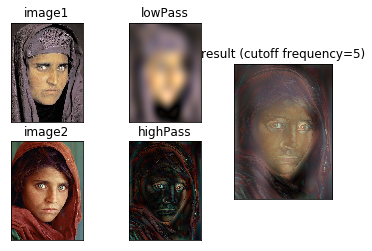

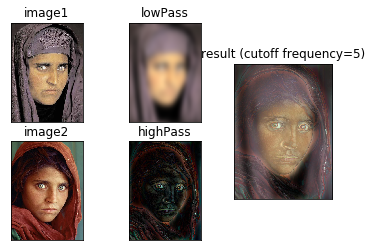

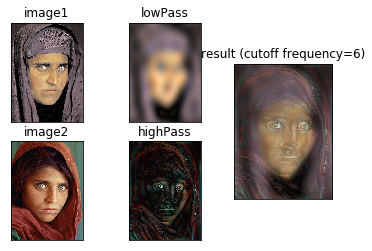

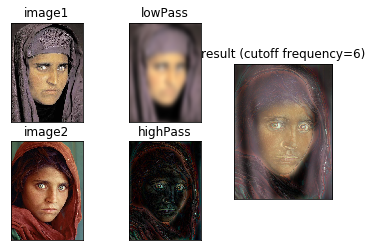

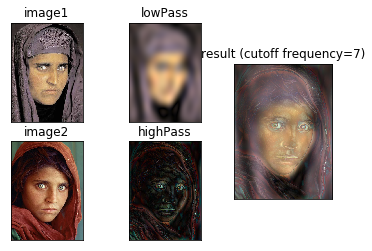

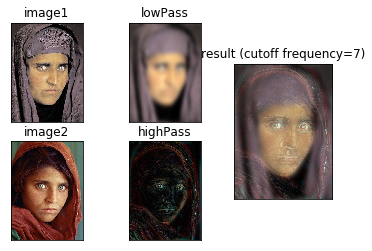

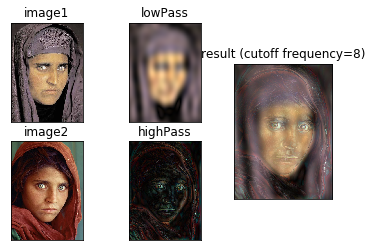

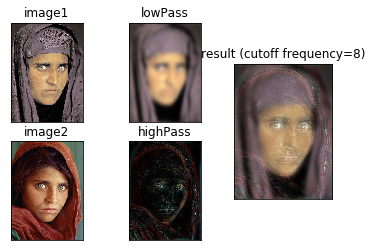

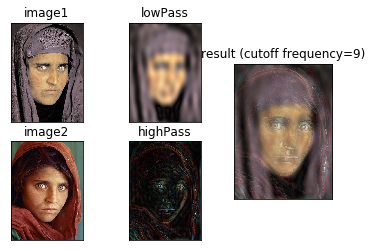

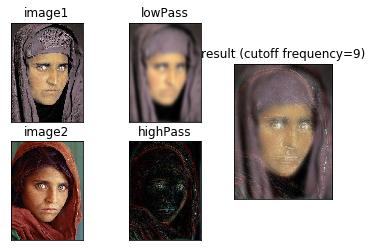

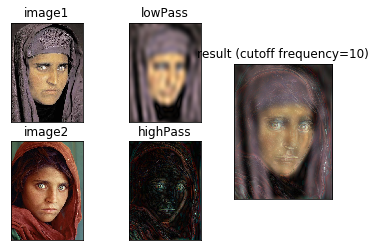

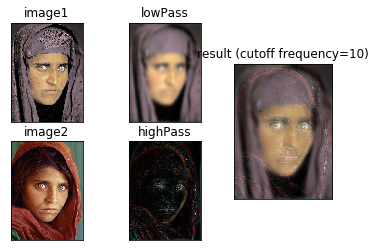

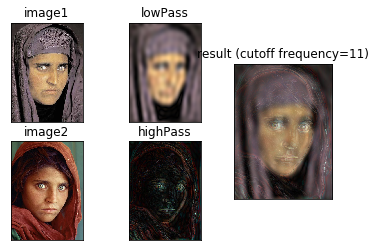

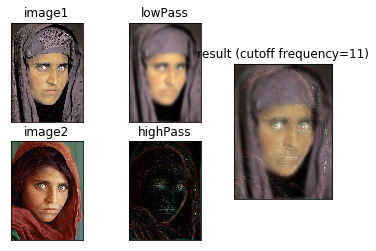

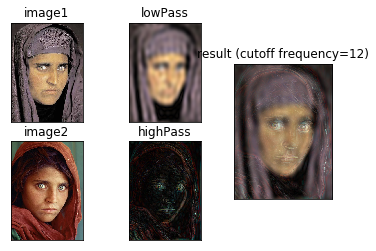

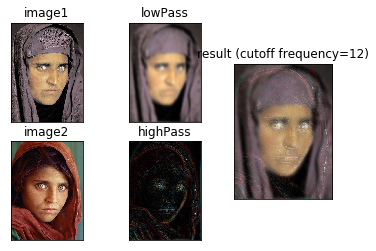

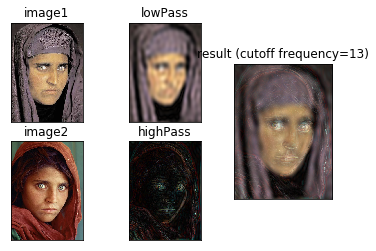

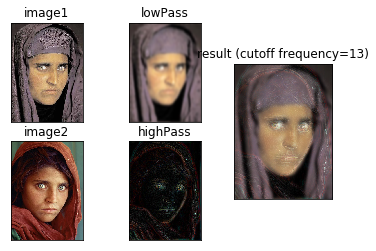

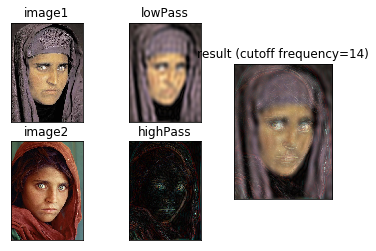

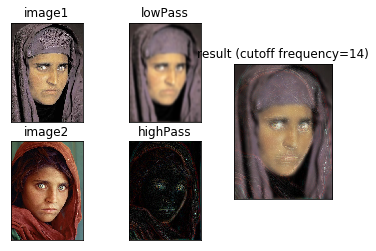

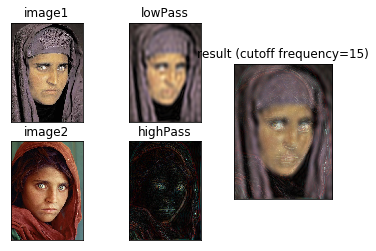

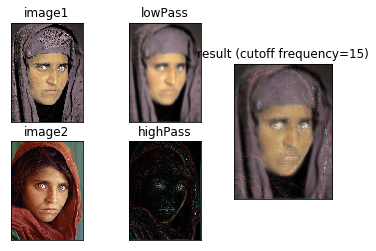

In [22]:
if __name__ == "__main__":
    root = os.path.join('hw2_data','task1,2_hybrid_pyramid')
    name1 = np.array(['0_Afghan_girl_after.jpg','1_bicycle.bmp','2_bird.bmp','3_cat.bmp','4_einstein.bmp','5_fish.bmp','6_makeup_after.jpg'])
    name2 = np.array(['0_Afghan_girl_before.jpg','1_motorcycle.bmp','2_plane.bmp','3_dog.bmp','4_marilyn.bmp','5_submarine.bmp','6_makeup_before.jpg'])
    cutoff_frequencies=[2,3,4,5,6,7,8,9,10,11,12,13,14,15] # bigger value -> clearer lowPass & less highPass
    # load images
    i=0
    
    img1 = cv2.imread(os.path.join(root,name1[i]))
    img2 = cv2.imread(os.path.join(root,name2[i]))
    if name1[i]=='6_makeup_after.jpg' and name2[i]=='6_makeup_before.jpg':
        img1=img1[:-1,:-1,:]
    
    for cutoff_frequency in cutoff_frequencies:
        for name,Filter in zip(['ideal','gaussian'],[idealFilter,GaussianFilter]):
            result,lowPassed,highPassed = hybrid(img1,img2,cutoff_frequency,Filter)

            plt.subplot(231), plt.imshow(img1[:,:,::-1]), plt.xticks([]), plt.yticks([]), plt.title('image1')
            plt.subplot(234), plt.imshow(img2[:, :, ::-1]), plt.xticks([]), plt.yticks([]), plt.title('image2')
            plt.subplot(232), plt.imshow(normalize(lowPassed)[:,:,::-1]), plt.xticks([]), plt.yticks([]), plt.title('lowPass')
            plt.subplot(235), plt.imshow(normalize(highPassed)[:,:,::-1]), plt.xticks([]), plt.yticks([]), plt.title('highPass')
            plt.subplot(133), plt.imshow(normalize(result)[:,:,::-1]), plt.xticks([]), plt.yticks([]), plt.title(f'result (cutoff frequency={cutoff_frequency})')
            plt.show()



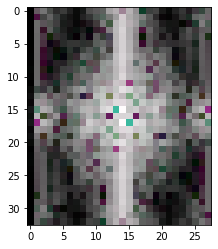

In [25]:
def GaussianFilter(frequency, highPass=False):
    # filter size
    size = 8 * frequency + 1
    if not size % 2:
        size = size + 1
    # lambda function for gaussian at i,j position
    gaussian = lambda i,j: np.exp(-1.0 * ((i - size//2)**2 + (j - size//2)**2) / (2 * frequency**2))
    k = np.array([[1-gaussian(i,j) if highPass else gaussian(i,j) for j in range(size)] for i in range(size)])
    return k/np.sum(k)

def filterDFT(img, filterH):
    k_h, k_w = filterH.shape[0],filterH.shape[1]
    start_h,start_w = (img.shape[0] - k_h) // 2, (img.shape[1] - k_w) // 2
    pad_filter = np.zeros(img.shape[:2])
    pad_filter[start_h : start_h + k_h, start_w : start_w + k_w] = filterH # pad the filter

    # ft the filter
    filt_fft = np.fft.fft2(pad_filter)
    # RGB
    if len(img.shape) == 3:
        result = np.zeros(img.shape)
        # for RGB
        for color in range(3):
            img_fft = np.fft.fft2(img[:, :, color])
            result[:, :, color] = np.fft.fftshift(np.fft.ifft2(img_fft * filt_fft)).real # apply the filter
        return result
    else: # gray
        img_fft = np.fft.fft2(img)
        result_img = np.fft.ifft2(img_fft * filt_fft).real # apply the filter
        return np.fft.fftshift(result_img)

def subsampling(img):
    newImg = np.zeros((img.shape[0]//2,img.shape[1]//2,3)) if len(img.shape) == 3 else np.zeros((img.shape[0]//2,img.shape[1]//2))
    # for each row and column pick the even pixel
    for i in range(newImg.shape[0]):
        for j in range(newImg.shape[1]):
            newImg[i][j] = img[2*i][2*j]
    return newImg
def upsampling(img,old_result):
    # calculate the difference of size between upsampling image and origin image
    padc, padr = np.array(old_result.shape[:2]) - np.array(img.shape[:2])*2
    # column interpolation
    col_idx = (np.ceil(np.arange(1, 1 + img.shape[0]*2)//2) - 1).astype(int)
    # row interpolation 
    row_idx = (np.ceil(np.arange(1, 1 + img.shape[1]*2)//2) - 1).astype(int)
    result = img[:, row_idx][col_idx, :]
    # if RGB
    if len(img.shape) == 3:
        # pad 0 to match the size of old image
        return np.pad(result,((padc,0),(padr,0),(0,0)),"constant")
    else: # gray
        return np.pad(result,((padc,0),(padr,0)),"constant")

## convert img to spectrum
def img_to_spectrum(img):
    # if RGB
    if len(img.shape) == 3:
        result = np.zeros(img.shape)
        for color in range(3):
            result[:, :, color] = np.fft.fft2(img[:, :, color]).real
        return normalize(np.log(1+np.abs(np.fft.fftshift(result)))) # normalizing result
    else: # gray
        return normalize(np.log(1+np.abs(np.fft.fftshift(np.fft.fft2(img))))) # normalizing result

def normalize(img):
    """
    normalize img to 0~1
    """
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

if __name__ == "__main__":
    root = os.path.join('hw2_data','task1,2_hybrid_pyramid')
    name='4_einstein.bmp'
    step=4
    img1 = cv2.imread(os.path.join(root,name))
    result = img1
    for i in range(step):
        old_result = result
        result = filterDFT(result,GaussianFilter(2))

        gaussian_spectrum = img_to_spectrum(result)
        plt.imshow(gaussian_spectrum)

        if i == 4:
            Laplacian = result
        else:
            result = subsampling(result)
            result2 = upsampling(result,old_result)
            Laplacian = old_result - result2

        Laplacian_spectrum = img_to_spectrum(Laplacian)
        plt.imshow(Laplacian_spectrum)
        cv2.waitKey(3000)
        cv2.destroyAllWindows()